# 1. Perkenalan Dataset
Tahap pertama dalam pelaksanaan kegiatan ini adalah melakukan pengumpulan dan penyusunan dataset pegawai sebagai dasar untuk membangun sistem rekomendasi saran pengembangan berbasis machine learning.

**1. Sumber Dataset**
Dataset diperoleh dengan mengekstrak data dari beberapa aplikasi milik Kementerian Pariwisata, seperti E-Kinerja dan E-Talenta.
- E-Talenta : digunakan untuk memperoleh data hasil assessment kompetensi pegawai yang masih berlaku.
- E-Kinerja : digunakan untuk memperoleh data penilaian kinerja (SKP) pegawai tahun 2024.

Selain itu, dilakukan pula pembuatan data dummy tambahan untuk melengkapi variasi kondisi gap kompetensi yang belum terwakili dalam data aktual, khususnya untuk gap >= 2 pada level kompetensi tertentu.


**2. Ketentuan Dataset**

- **Label** : dataset memiliki label yang dikaitkan dengan kompetensi pegawai dan terbagi ke dalam tiga aspek utama:
  - Pengetahuan
  - Keahlian
  - Pribadi

  Untuk setiap kompetensi yang memiliki gap, dibuat minimal satu saran pengembangan untuk masing-masin aspek. Misalnya, jika pegawai memiliki gap pada kompetensi "Kerjasama", maka akan terdapat tiga baris data, masing-masing berisi saran aspek pengetahuan, keahlian dan pribadi.
  - **Jumlah Baris** : Dataset yang digunakan memiliki minimal 1000 baris, gabungan antara data pegawai aktual dan data dummy, untuk memastikan ukuran data cukup besar untuk keperluan analisis dan pelatihan model machine learning.
  - **Tipe Data** : dataset terdiri dari kombinasi variabel kategorikal dan numerikal
    - Kategorikal : level kompetensi, aspek
    - Numerikal : nilai, gap

**3. Pembatasan**
Dataset adalah sampel data pegawai kementerian pariwisata yang telah melakukan assessment maksimal tahun 2022 dan memiliki penilaian SKP di tahun 2024. Data dummy dibuat dengan struktur yang sama seperti data aktual, tetapi menggunakan informasi fiktif (khususnya untuk satker dan jabatan) untuk menjaga konsistensi format tanpa melanggar kerahasiaan data pegawai.




# 2. Import Library
Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 3. Memuat Dataset

Pada tahap ini, dimuat dataset ke dalam notebook. Dataset memiliki format CSV, maka perlu dicek beberapa baris awal untuk memahami struktur dan memastikan data telah dimuat dengan benar

In [24]:
history_recomm_real_data = pd.read_csv("C:\Josephine Work File - 2025\Latsar Aktualisasi\sistem-rekomendasi-saran-pengembangan\data\dataset_dummy_recomendation - real_data.csv")
history_recomm_real_data.head()

<>:1: SyntaxWarning: invalid escape sequence '\J'
<>:1: SyntaxWarning: invalid escape sequence '\J'
C:\Users\josep\AppData\Local\Temp\ipykernel_6804\2428400297.py:1: SyntaxWarning: invalid escape sequence '\J'
  history_recomm_real_data = pd.read_csv("C:\Josephine Work File - 2025\Latsar Aktualisasi\sistem-rekomendasi-saran-pengembangan\data\dataset_dummy_recomendation - real_data.csv")


,nama,nip,satker,jabatan,kinerja,kompetensi,standar level,nilai,gap,aspek,feedback_terakhir,saran_pengembangan,is_dummy
0,ni made ayu marthini,197105121996032001,deputi bidang pemasaran,deputi bidang pemasaran,baik,integritas,5,4.60,-0.40,keahlian,Sangat Efektif,penugasan khusus,0.0
1,ni made ayu marthini,197105121996032001,deputi bidang pemasaran,deputi bidang pemasaran,baik,integritas,5,4.60,-0.40,pengetahuan,Sangat Efektif,patok banding,0.0
2,ni made ayu marthini,197105121996032001,deputi bidang pemasaran,deputi bidang pemasaran,baik,integritas,5,4.60,-0.40,personal atribute,Sangat Efektif,konseling,0.0
3,ni made ayu marthini,197105121996032001,deputi bidang pemasaran,deputi bidang pemasaran,baik,kerjasama,5,4.83,-0.17,pengetahuan,Sangat Efektif,patok banding,0.0
4,ni made ayu marthini,197105121996032001,deputi bidang pemasaran,deputi bidang pemasaran,baik,kerjasama,5,4.83,-0.17,keahlian,Sangat Efektif,pelatihan lemhannas,0.0


In [25]:
history_recomm_real_data["nip"] = history_recomm_real_data["nip"].astype(str)

In [26]:
history_recomm_dummy_data = pd.read_csv("C:\Josephine Work File - 2025\Latsar Aktualisasi\sistem-rekomendasi-saran-pengembangan\data\dataset_dummy_recomendation - dummy_data.csv")
history_recomm_dummy_data.head()

<>:1: SyntaxWarning: invalid escape sequence '\J'
<>:1: SyntaxWarning: invalid escape sequence '\J'
C:\Users\josep\AppData\Local\Temp\ipykernel_6804\2054136291.py:1: SyntaxWarning: invalid escape sequence '\J'
  history_recomm_dummy_data = pd.read_csv("C:\Josephine Work File - 2025\Latsar Aktualisasi\sistem-rekomendasi-saran-pengembangan\data\dataset_dummy_recomendation - dummy_data.csv")


,nama,nip,satker,jabatan,kinerja,kompetensi,standar level,nilai,gap,aspek,feedback_terakhir,saran_pengembangan,is_dummy
0,dummy 1,NaN,NaN,NaN,baik,integritas,5,3,-2,pengetahuan,efektif,pelatihan kode etik dan kode perilaku,1
1,dummy 1,NaN,NaN,NaN,baik,integritas,5,3,-2,keahlian,sangat efektif,bimbingan teknis,1
2,dummy 1,NaN,NaN,NaN,baik,integritas,5,3,-2,personal atribute,efektif,konseling,1
3,dummy 1,NaN,NaN,NaN,baik,kerjasama,5,3,-2,pengetahuan,tidak efektif,pembelajaran mandiri,1
4,dummy 1,NaN,NaN,NaN,baik,kerjasama,5,3,-2,keahlian,efektif,pelatihan lemhannas,1


**Gabungkan data historis dan data dummy menjadi satu dataset utuh**

In [27]:
combined_df = pd.concat([history_recomm_real_data, history_recomm_dummy_data], ignore_index=True)

# gabung dan cek apakah ada duplikasi baris
combined_df.drop_duplicates(inplace=True)

# simpan hasil gabungan
combined_df.to_csv('dataset_combined.csv', index=False)

print(f"Dataset final memiliki {len(combined_df)} baris")

Dataset final memiliki 2820 baris


In [28]:
combined_df.head()

,nama,nip,satker,jabatan,kinerja,kompetensi,standar level,nilai,gap,aspek,feedback_terakhir,saran_pengembangan,is_dummy
0,ni made ayu marthini,197105121996032001,deputi bidang pemasaran,deputi bidang pemasaran,baik,integritas,5,4.60,-0.40,keahlian,Sangat Efektif,penugasan khusus,0.0
1,ni made ayu marthini,197105121996032001,deputi bidang pemasaran,deputi bidang pemasaran,baik,integritas,5,4.60,-0.40,pengetahuan,Sangat Efektif,patok banding,0.0
2,ni made ayu marthini,197105121996032001,deputi bidang pemasaran,deputi bidang pemasaran,baik,integritas,5,4.60,-0.40,personal atribute,Sangat Efektif,konseling,0.0
3,ni made ayu marthini,197105121996032001,deputi bidang pemasaran,deputi bidang pemasaran,baik,kerjasama,5,4.83,-0.17,pengetahuan,Sangat Efektif,patok banding,0.0
4,ni made ayu marthini,197105121996032001,deputi bidang pemasaran,deputi bidang pemasaran,baik,kerjasama,5,4.83,-0.17,keahlian,Sangat Efektif,pelatihan lemhannas,0.0


In [29]:
combined_df.tail()

,nama,nip,satker,jabatan,kinerja,kompetensi,standar level,nilai,gap,aspek,feedback_terakhir,saran_pengembangan,is_dummy
2820,dummy 19,NaN,NaN,NaN,baik,perekat bangsa,2,0.0,-2.0,keahlian,cukup efektif,bimbingan teknis,1.0
2821,dummy 19,NaN,NaN,NaN,baik,perekat bangsa,2,0.0,-2.0,personal atribut,sangat efektif,pembelajaran alam terbuka,1.0
2822,dummy 19,NaN,NaN,NaN,baik,mengelola perubahan,2,0.0,-2.0,pengetahuan,efektif,e-learning,1.0
2823,dummy 19,NaN,NaN,NaN,baik,mengelola perubahan,2,0.0,-2.0,keahlian,cukup efektif,magang,1.0
2824,dummy 19,NaN,NaN,NaN,baik,mengelola perubahan,2,0.0,-2.0,personal atribut,sangat efektif,konseling,1.0


In [30]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2820 entries, 0 to 2824
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   nama                2820 non-null   object 
 1   nip                 2332 non-null   object 
 2   satker              2332 non-null   object 
 3   jabatan             2332 non-null   object 
 4   kinerja             2820 non-null   object 
 5   kompetensi          2820 non-null   object 
 6   standar level       2820 non-null   int64  
 7   nilai               2820 non-null   float64
 8   gap                 2820 non-null   float64
 9   aspek               2820 non-null   object 
 10  feedback_terakhir   2820 non-null   object 
 11  saran_pengembangan  2820 non-null   object 
 12  is_dummy            1148 non-null   float64
dtypes: float64(3), int64(1), object(9)
memory usage: 308.4+ KB


# 4. Expoloratory Data Analysis (EDA)

Pada tahap ini, dilakukan exploratory data analysis untuk memahami karakteristik dataset. EDA bertujuan untuk :

1. **Memahami Struktur Data**
    - Tinjau jumlah baris dan kolom dalam dataset
    - Tinjau jenis data di setiap kolom (numerikal atau kategorikal)
2. **Menangani Data yang Hilang**
    - Identifikasi dan analisis data yang hilang (missing values) dengan pengisian data.
3. **Analisis Distribusi dan Korelasi**
    - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram.
    - Periksa hubungan antara variabel menggunakan matriks korelasi
4. **Visualisasi Data**
    - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal
    - Gunakan heatmap untuk menganalisis korelasi antar variabel


**Memahami Struktur Data**

In [31]:
df = pd.read_csv('dataset_combined.csv')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   nama                2820 non-null   object 
 1   nip                 2332 non-null   float64
 2   satker              2332 non-null   object 
 3   jabatan             2332 non-null   object 
 4   kinerja             2820 non-null   object 
 5   kompetensi          2820 non-null   object 
 6   standar level       2820 non-null   int64  
 7   nilai               2820 non-null   float64
 8   gap                 2820 non-null   float64
 9   aspek               2820 non-null   object 
 10  feedback_terakhir   2820 non-null   object 
 11  saran_pengembangan  2820 non-null   object 
 12  is_dummy            1148 non-null   float64
dtypes: float64(4), int64(1), object(8)
memory usage: 286.5+ KB


Dari output di atas, diketahui bahwa selain kolom nip, standar level, nilai, gap dan is_dummy, data pada kolom lain memiliki tipe object

In [33]:
df.describe()

,nip,standar level,nilai,gap,is_dummy
count,2.332000e+03,2820.000000,2820.000000,2820.000000,1148.000000
mean,1.976483e+17,2.965603,2.141649,-0.818539,0.425087
std,9.479228e+14,1.364380,1.276675,1.221478,0.494572
min,1.962090e+17,1.000000,0.000000,-5.000000,0.000000
25%,1.969071e+17,2.000000,1.000000,-1.000000,0.000000
50%,1.973020e+17,3.000000,2.000000,-0.250000,0.000000
75%,1.982092e+17,4.000000,3.000000,0.000000,1.000000
max,1.999082e+17,5.000000,5.000000,1.000000,1.000000


In [34]:
df.isnull().sum()

nama                     0
nip                    488
satker                 488
jabatan                488
kinerja                  0
kompetensi               0
standar level            0
nilai                    0
gap                      0
aspek                    0
feedback_terakhir        0
saran_pengembangan       0
is_dummy              1672
dtype: int64

Dari hasil pengecekan data kosong di atas, dataset memiliki nilai null pada baris nip, satker, jabatan dan is_dummy. Nilai null ini akan mempengaruhi pembangunan model ML dan perlu ditangani dengan pengisian data

**Analisis Distribusi Korelasi**

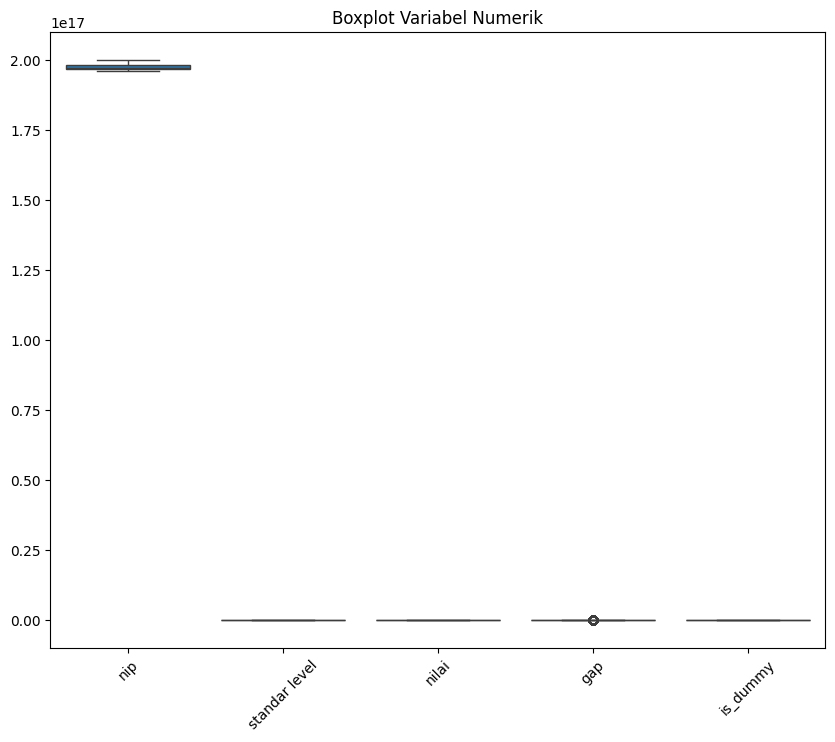

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot untuk semua variabel numerik
plt.figure(figsize=(10, 8))
sns.boxplot(data=df.select_dtypes(include=['int64', 'float64']))
plt.xticks(rotation=45)
plt.title('Boxplot Variabel Numerik')
plt.show()

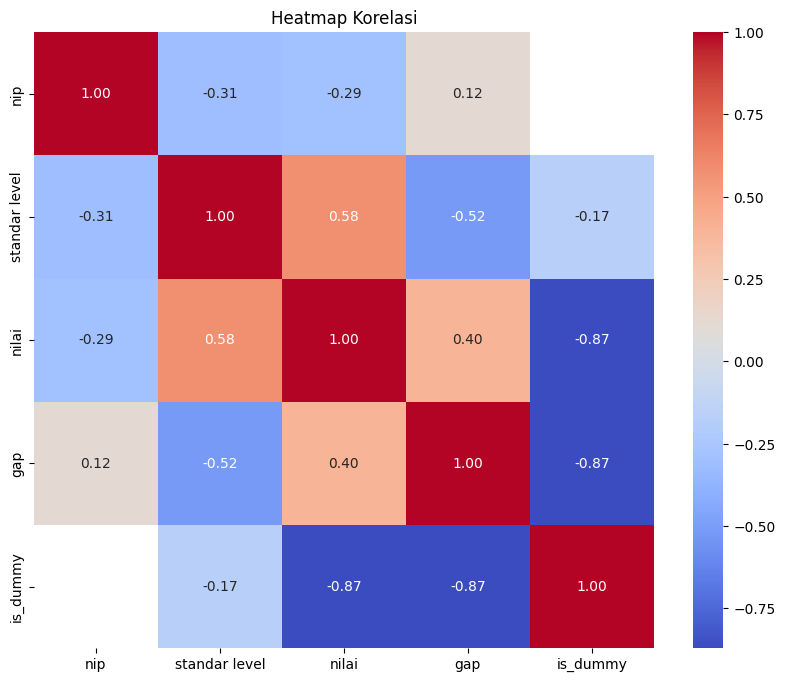

In [36]:
# Memilih hanya kolom numerik
numeric_data = df.select_dtypes(include=['number'])

# Menghitung matriks korelasi
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi')
plt.show()

**Visualisasi Data**

C:\Users\josep\AppData\Local\Temp\ipykernel_6804\769364608.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='feedback_terakhir', data=df, palette='pastel')


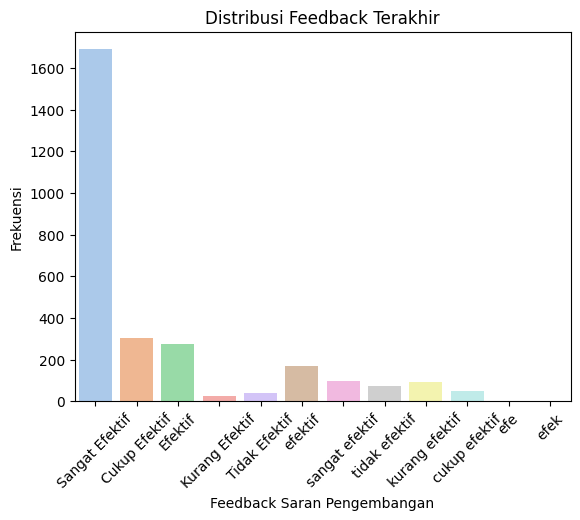

In [37]:
# Diagram batang untuk variabel kategorikal, contoh: 'feedback_terakhir'
sns.countplot(x='feedback_terakhir', data=df, palette='pastel')
plt.title('Distribusi Feedback Terakhir')
plt.xlabel('Feedback Saran Pengembangan')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45)
plt.show()

Berdasarkan hasil eksplorasi data terhadap variabel feedback terakhir, ditemukan inkonsistensi penulisan label, seperti munculnya variasi penulisan “Efektif” menjadi “efektif”, “efe”, atau “efek”, yang menyebabkan fragmentasi kategori dan memperparah ketidakseimbangan distribusi.

Permasalahan ini dapat berdampak pada performa model, terutama jika model menganggap setiap variasi tulisan sebagai kelas yang berbeda. Untuk mengatasi hal tersebut, dilakukan langkah-langkah berikut:
  - Standarisasi penulisan label melalui text cleaning, misalnya dengan mengubah semua label menjadi huruf kecil dan melakukan mapping ke kategori baku.
  - Penggabungan kategori yang serupa ke dalam satu label utama. Contoh: “efe” dan “efek” dikoreksi menjadi “efektif”.

C:\Users\josep\AppData\Local\Temp\ipykernel_6804\1891498694.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='aspek', data=df, palette='pastel')


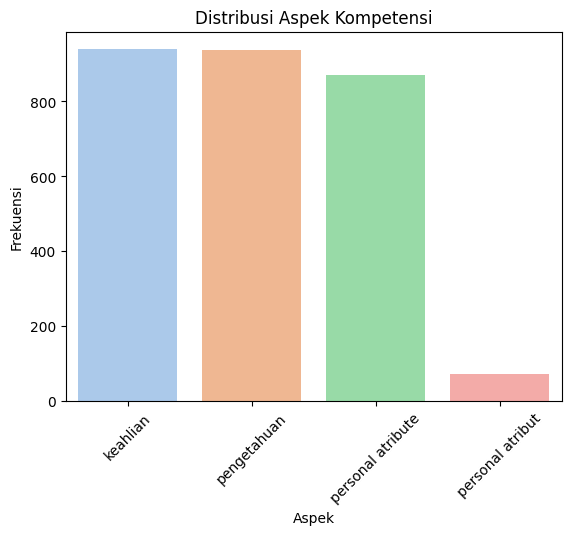

In [38]:
# Diagram batang untuk variabel kategorikal, contoh: 'aspek'
sns.countplot(x='aspek', data=df, palette='pastel')
plt.title('Distribusi Aspek Kompetensi')
plt.xlabel('Aspek')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45)
plt.show()

Dari tampilan diagram di atas, terdapat ketidakseimbangan persebaran aspek di dataset. Hal ini perlu ditindaklanjuti dengan mapping ulang baris aspek menjadi tiga aspek : pengetahuan, keahlian dan personal atribute

# 5. Data Preprocessing

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Langkah-langkah yang dilakukan dalam proses ini meliputi:

**Pembersihan Data (Data Cleaning)**
- Menghapus entri duplikat yang dapat menyebabkan bias pada model.
- Menstandarkan format penulisan, seperti pada kolom kategori “Feedback Saran Pengembangan” yang sebelumnya mengandung variasi penulisan (misalnya “Efektif”, “efektif”, “efe”) agar seragam dan dapat diolah dengan benar.
- Menangani nilai kosong (missing values) untuk memastikan tidak ada informasi penting yang hilang atau menyebabkan error saat pemrosesan selanjutnya.

**Validasi Kualitas dan Kuantitas Data**
- Mengukur persentase data bersih (tanpa nilai kosong atau duplikasi) setelah proses cleaning.

**Penanganan Ketidakseimbangan Distribusi Data**
- Distribusi data pada kolom Standar Level menunjukkan ketidakseimbangan yang cukup signifikan.
- Untuk mengatasi hal ini dilakukan penambahan data dummy pada kelas yang kurang representatif agar distribusi data menjadi lebih seimbang dan model tidak bias terhadap kelas mayoritas.

**Encoding dan Transformasi Data**
- Mengubah fitur kategorikal menjadi format numerik yang dapat dipahami model menggunakan teknik encoding yang sesuai.
- Normalisasi atau standarisasi diterapkan bila diperlukan, terutama untuk fitur numerik agar skala antar variabel seragam.

**Menghapus/Menangani Data Kosong**

Nilai kosong pada kolom identitas (NIP, satker, dan jabatan) diisi dengan placeholder agar struktur dataset tetap konsisten tanpa menghapus baris data yang memuat informasi penting terkait kompetensi, gap, dan feedback. Hal ini dilakukan karena ketiga kolom tersebut tidak digunakan sebagai fitur dalam proses pelatihan model machine learning

In [39]:
# Buat salinan dataframe untuk data preprocessing
df_clean = df.copy()

# Isi nilai kosong pada kolom identitas dengan placeholder di salinan, bukan df asli
df_clean['nip'] = df_clean['nip'].fillna('DUMMY')
df_clean['satker'] = df_clean['satker'].fillna('Tidak diketahui')
df_clean['jabatan'] = df_clean['jabatan'].fillna('Tidak diketahui')
df_clean['is_dummy'] = df_clean['is_dummy'].fillna('DUMMY')

# Cek beberapa baris untuk memastikan perubahan hanya terjadi di df_clean
print(df_clean.tail())

          nama    nip           satker          jabatan kinerja  \
2815  dummy 19  DUMMY  Tidak diketahui  Tidak diketahui    baik   
2816  dummy 19  DUMMY  Tidak diketahui  Tidak diketahui    baik   
2817  dummy 19  DUMMY  Tidak diketahui  Tidak diketahui    baik   
2818  dummy 19  DUMMY  Tidak diketahui  Tidak diketahui    baik   
2819  dummy 19  DUMMY  Tidak diketahui  Tidak diketahui    baik   

               kompetensi  standar level  nilai  gap             aspek  \
2815       perekat bangsa              2    0.0 -2.0          keahlian   
2816       perekat bangsa              2    0.0 -2.0  personal atribut   
2817  mengelola perubahan              2    0.0 -2.0       pengetahuan   
2818  mengelola perubahan              2    0.0 -2.0          keahlian   
2819  mengelola perubahan              2    0.0 -2.0  personal atribut   

     feedback_terakhir         saran_pengembangan is_dummy  
2815     cukup efektif           bimbingan teknis      1.0  
2816    sangat efektif  pembel

In [40]:
# Cek ulang apakah masih ada nilai kosong
print(df_clean.isnull().sum())
print(df_clean.isna().sum())

nama                  0
nip                   0
satker                0
jabatan               0
kinerja               0
kompetensi            0
standar level         0
nilai                 0
gap                   0
aspek                 0
feedback_terakhir     0
saran_pengembangan    0
is_dummy              0
dtype: int64
nama                  0
nip                   0
satker                0
jabatan               0
kinerja               0
kompetensi            0
standar level         0
nilai                 0
gap                   0
aspek                 0
feedback_terakhir     0
saran_pengembangan    0
is_dummy              0
dtype: int64


**Menghapus Entri Duplikat**

In [41]:
# Buat salinan dataframe untuk data preprocessing
df_drop = df_clean.copy()

# Jumlah data sebelum penghapusan duplikat
print(f"Jumlah data sebelum drop duplicates: {len(df_drop)}")

# Hapus duplikat (berdasarkan semua kolom)
df_drop = df_drop.drop_duplicates()

# Jumlah data setelah penghapusan duplikat
print(f"Jumlah data setelah drop duplicates: {len(df_drop)}")

Jumlah data sebelum drop duplicates: 2820
Jumlah data setelah drop duplicates: 2820


**Menstandarkan Format Penulisan Kolom Kategori**

In [42]:
# Buat salinan dataframe untuk data preprocessing
df_final = df_drop.copy()

# Ubah semua ke huruf kecil dan hilangkan spasi di awal/akhir
df_final['feedback_terakhir'] = df_final['feedback_terakhir'].str.strip().str.lower()
df_final['aspek'] = df_final['aspek'].str.strip().str.lower()

# Buat peta standarisasi kata-kata yang typo atau tidak seragam
mapping_feedback = {
    'efektif': 'efektif',
    'efe': 'efektif',
    'efek': 'efektif',
    'sangat efektif': 'sangat efektif',
    'Sangat Efektif': 'sangat efektif',
    'tidak efektif': 'tidak efektif',
    'Tidak Efektif': 'tidak efektif',
    'kurang efektif': 'kurang efektif',
    'Kurang Efektif': 'kurang efektif',
    'cukup efektif': 'cukup efektif',
    'Cukup Efektif': 'cukup efektif'
}

mapping_aspek = {
    # Pengetahuan
    'pengetahuan': 'pengetahuan',

    # Keahlian
    'keahlian': 'keahlian',

    # Personal Attribute
    'personal atribute': 'personal atribute',
    'personal atribut': 'personal atribute',
    'atribut personal': 'personal atribute',
    'personal attribute': 'personal atribute',
}

# Terapkan standarisasi
df_final['feedback_terakhir'] = df_final['feedback_terakhir'].replace(mapping_feedback)
df_final['aspek'] = df_final['aspek'].replace(mapping_aspek)

# Cek hasil unik setelah standarisasi
print(df_final['feedback_terakhir'].unique())
print(df_final['aspek'].unique())


['sangat efektif' 'cukup efektif' 'efektif' 'kurang efektif'
 'tidak efektif']
['keahlian' 'pengetahuan' 'personal atribute']


**Validasi Kualitas dan Kuantitas Data**

In [43]:
# Hitung total data awal
total_awal = len(df)

# Hitung total data bersih
total_bersih = len(df_final)

# Hitung persentase
persentase_bersih = (total_bersih / total_awal) * 100

print(f"Total data awal: {total_awal}")
print(f"Total data setelah cleaning: {total_bersih}")
print(f"Persentase data bersih: {persentase_bersih:.2f}%")

Total data awal: 2820
Total data setelah cleaning: 2820
Persentase data bersih: 100.00%


In [44]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   nama                2820 non-null   object 
 1   nip                 2820 non-null   object 
 2   satker              2820 non-null   object 
 3   jabatan             2820 non-null   object 
 4   kinerja             2820 non-null   object 
 5   kompetensi          2820 non-null   object 
 6   standar level       2820 non-null   int64  
 7   nilai               2820 non-null   float64
 8   gap                 2820 non-null   float64
 9   aspek               2820 non-null   object 
 10  feedback_terakhir   2820 non-null   object 
 11  saran_pengembangan  2820 non-null   object 
 12  is_dummy            2820 non-null   object 
dtypes: float64(2), int64(1), object(10)
memory usage: 286.5+ KB


In [45]:
df_final.head()

,nama,nip,satker,jabatan,kinerja,kompetensi,standar level,nilai,gap,aspek,feedback_terakhir,saran_pengembangan,is_dummy
0,ni made ayu marthini,197105121996032000.0,deputi bidang pemasaran,deputi bidang pemasaran,baik,integritas,5,4.60,-0.40,keahlian,sangat efektif,penugasan khusus,0.0
1,ni made ayu marthini,197105121996032000.0,deputi bidang pemasaran,deputi bidang pemasaran,baik,integritas,5,4.60,-0.40,pengetahuan,sangat efektif,patok banding,0.0
2,ni made ayu marthini,197105121996032000.0,deputi bidang pemasaran,deputi bidang pemasaran,baik,integritas,5,4.60,-0.40,personal atribute,sangat efektif,konseling,0.0
3,ni made ayu marthini,197105121996032000.0,deputi bidang pemasaran,deputi bidang pemasaran,baik,kerjasama,5,4.83,-0.17,pengetahuan,sangat efektif,patok banding,0.0
4,ni made ayu marthini,197105121996032000.0,deputi bidang pemasaran,deputi bidang pemasaran,baik,kerjasama,5,4.83,-0.17,keahlian,sangat efektif,pelatihan lemhannas,0.0


# 6. Uji Coba Dataset

Melatih
 model sederhana untuk
 menguji apakah dataset
 sudah layak digunakan

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from joblib import dump
from collections import Counter

# --- 1. Siapkan data ---
features = ["kompetensi", "standar level", "nilai", "gap", "aspek", "feedback_terakhir"]
target = "saran_pengembangan"

X = df_final[features]
y = df_final[target]

num_cols = ["standar level", "nilai", "gap"]
cat_cols = ["kompetensi", "aspek", "feedback_terakhir"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
])

# Buang kelas yang terlalu sedikit
counts = Counter(y)
valid_classes = [cls for cls, cnt in counts.items() if cnt >= 2]
mask = y.isin(valid_classes)
X = X[mask]
y = y[mask]

# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


# --- 2. Split data ---
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, stratify=y_encoded, random_state=42, test_size=0.2
)

# --- 3. Definisikan model ---
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, multi_class='auto')
}

# (Opsional) Jika XGBoost tersedia
try:
    from xgboost import XGBClassifier
    models["XGBoost"] = XGBClassifier(random_state=42)
except ImportError:
    print("⚠️ XGBoost tidak terpasang, lewati model XGBClassifier.")

# --- 4. Latih & Evaluasi semua model ---
results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[("pre", preprocessor), ("model", model)])
    # Use the encoded target variable for training and evaluation
    pipe.fit(X_train, y_train_encoded)
    y_pred_encoded = pipe.predict(X_test)
    acc = accuracy_score(y_test_encoded, y_pred_encoded)
    results[name] = {"model": pipe, "accuracy": acc}
    print(f"{name} Accuracy: {acc:.4f}")

# --- 5. Pilih model terbaik ---
best_model_name = max(results, key=lambda x: results[x]["accuracy"])
best_model = results[best_model_name]["model"]
best_acc = results[best_model_name]["accuracy"]

print(f"\n🏆 Model terbaik: {best_model_name} (Accuracy = {best_acc:.4f})")

# --- 6. Simpan model terbaik ---
# You may also want to save the LabelEncoder if you need to decode predictions later
dump(best_model, "model_classification_best.joblib")
dump(label_encoder, "label_encoder.joblib")
print(f"✅ Model {best_model_name} dan LabelEncoder disimpan sebagai 'model_classification_best.joblib' dan 'label_encoder.joblib'")

⚠️ XGBoost tidak terpasang, lewati model XGBClassifier.
RandomForest Accuracy: 0.3837
GradientBoosting Accuracy: 0.3925


C:\Users\josep\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression Accuracy: 0.3677

🏆 Model terbaik: GradientBoosting (Accuracy = 0.3925)
✅ Model GradientBoosting dan LabelEncoder disimpan sebagai 'model_classification_best.joblib' dan 'label_encoder.joblib'


In [47]:
import numpy as np
import pandas as pd
from joblib import load

# === 1. Load model klasifikasi ===
clf_model = load("C:\Josephine Work File - 2025\Latsar Aktualisasi\sistem-rekomendasi-saran-pengembangan\model\model_classification_best.joblib")

# === 2. Contoh data pegawai baru ===
pegawai_baru = pd.DataFrame([{
    "kompetensi": "integritas",
    "standar level": 4,
    "nilai": 3,
    "gap": -1,
    "aspek" : "keahlian",
    "feedback_terakhir": "kurang efektif"
}])

# === 3. Prediksi probabilitas untuk semua kelas (saran pengembangan) ===
proba_clf = clf_model.predict_proba(pegawai_baru)[0]

# Ambil daftar kelas dari model (urutan sama dengan probabilitas)
clf_classes = clf_model.named_steps["model"].classes_

# === 4. Buat dictionary skor ===
scores = {clf_classes[i]: proba_clf[i] for i in range(len(clf_classes))}

# === 5. Ambil Top-3 rekomendasi ===
top_rekom = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]

# === 6. Tampilkan hasil ===
print("Top-3 Rekomendasi Saran Pengembangan:")
for rank, (saran, score) in enumerate(top_rekom, start=1):
    print(f"{rank}. {saran} (score: {score:.3f})")

<>:6: SyntaxWarning: invalid escape sequence '\J'
<>:6: SyntaxWarning: invalid escape sequence '\J'
C:\Users\josep\AppData\Local\Temp\ipykernel_6804\954316048.py:6: SyntaxWarning: invalid escape sequence '\J'
  clf_model = load("C:\Josephine Work File - 2025\Latsar Aktualisasi\sistem-rekomendasi-saran-pengembangan\model\model_classification_best.joblib")


Top-3 Rekomendasi Saran Pengembangan:
1. 27 (score: 0.593)
2. 3 (score: 0.246)
3. 1 (score: 0.105)


# 7. Model Development

*Model development* dengan *machine learning* menggunakan data kompetensi dan hasil pelatihan

In [48]:
df_final["saran_pengembangan"].value_counts()

saran_pengembangan
umpan balik                              457
konseling                                376
penugasan                                280
coaching                                 235
pembelajaran mandiri                     136
e-learning                               134
bimbingan teknis                         130
sosialisasi                              123
pembelajaran alam terbuka                 94
komunitas belajar                         90
patok banding                             89
studi kasus                               86
magang                                    71
mentoring                                 62
bimbingan di tempat kerja                 49
sarasehan                                 43
lokakarya                                 40
workshop                                  40
pelatihan lemhannas                       35
seminar nasional                          32
pelatihan komunikasi efektif              28
seminar                             

Kode ini digunakan untuk **menstandarkan penulisan pada kolom “saran_pengembangan”** agar konsisten.
Langkahnya: membuat salinan data (`df_fixed`), mendefinisikan daftar koreksi (`mapping`), mengganti nilai yang tidak baku dengan bentuk benar menggunakan `.replace()`, lalu menampilkan hasil per kategori dengan `.value_counts()` untuk memastikan data sudah bersih dan seragam.

In [49]:
df_fixed = df_final.copy()

# Buat dictionary mapping dari bentuk salah ke bentuk benar
mapping = {
    "menjadi nara sumber": "menjadi narasumber",
    "penugasaran": "penugasan",
    "semin": "seminar",
    "pembelajarn alam terbuka": "pembelajaran alam terbuka",
    "pelatihan teks": "pelatihan teknis",
    "konferensi nasional": "konferensi",
    "pelatihan": "pelatihan teknis",
    "counseling": "penugasan"
}

# Terapkan mapping ke kolom target
df_fixed["saran_pengembangan"] = df_fixed["saran_pengembangan"].replace(mapping)

# Cek ulang hasilnya
print(df_fixed["saran_pengembangan"].value_counts())


saran_pengembangan
umpan balik                              457
konseling                                376
penugasan                                282
coaching                                 235
pembelajaran mandiri                     136
e-learning                               134
bimbingan teknis                         130
sosialisasi                              123
pembelajaran alam terbuka                 95
komunitas belajar                         90
patok banding                             89
studi kasus                               86
magang                                    71
mentoring                                 62
bimbingan di tempat kerja                 49
sarasehan                                 43
lokakarya                                 40
workshop                                  40
pelatihan lemhannas                       35
seminar nasional                          32
seminar                                   29
pelatihan teknis                    

Kode ini berfungsi untuk **menyeimbangkan jumlah data pada setiap kategori di kolom “saran_pengembangan”** agar model tidak bias terhadap kelas dengan data lebih banyak.

Langkahnya:

1. Menentukan batas minimal data per kelas (`min_count = 50`).
2. Mengelompokkan data berdasarkan kategori.
3. Melakukan **replikasi (oversampling)** untuk kategori dengan jumlah data di bawah batas minimal, baik dengan penggandaan penuh maupun penambahan acak.
4. Menggabungkan seluruh hasil menjadi dataset baru (`df_balanced`).
5. Menampilkan distribusi akhir tiap kategori untuk memastikan data sudah seimbang.

In [50]:
target_col = "saran_pengembangan"

# Tentukan jumlah minimal per kelas
min_count = 50

# Buat list untuk menampung DataFrame hasil replikasi
augmented_dfs = []

for saran, group in df_final.groupby(target_col):
    count = len(group)
    if count < min_count:
        # Hitung berapa kali perlu direplikasi
        repeat_times = min_count // count
        remainder = min_count % count

        # Duplikasi penuh
        df_repeated = pd.concat([group] * repeat_times, ignore_index=True)

        # Tambah sisa baris secara acak
        if remainder > 0:
            df_remainder = group.sample(n=remainder, replace=True, random_state=42)
            df_repeated = pd.concat([df_repeated, df_remainder], ignore_index=True)

        augmented_dfs.append(df_repeated)
    else:
        # Kalau jumlah baris sudah cukup, tetap masukkan originalnya
        augmented_dfs.append(group)

# Gabungkan semua hasilnya
df_balanced = pd.concat(augmented_dfs, ignore_index=True)

# Cek distribusi baru
print(df_balanced[target_col].value_counts())

saran_pengembangan
umpan balik                              457
konseling                                376
penugasan                                280
coaching                                 235
pembelajaran mandiri                     136
e-learning                               134
bimbingan teknis                         130
sosialisasi                              123
pembelajaran alam terbuka                 94
komunitas belajar                         90
patok banding                             89
studi kasus                               86
magang                                    71
mentoring                                 62
kelompok belajar                          50
bimbingan teknis di pekerjaan             50
menjadi narasumber                        50
menjadi nara sumber                       50
kursus                                    50
lokakarya                                 50
konferensi nasional                       50
bimbingan di tempat kerja           

**Training Ulang dengan dataset baru**

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from joblib import dump
from collections import Counter

# --- 1. Siapkan data ---
features = ["kompetensi", "standar level", "nilai", "gap", "aspek", "feedback_terakhir"]
target = "saran_pengembangan"

X = df_balanced[features]
y = df_balanced[target]

num_cols = ["standar level", "nilai", "gap"]
cat_cols = ["kompetensi", "aspek", "feedback_terakhir"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
])

# Buang kelas yang terlalu sedikit
counts = Counter(y)
valid_classes = [cls for cls, cnt in counts.items() if cnt >= 2]
mask = y.isin(valid_classes)
X = X[mask]
y = y[mask]

# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


# --- 2. Split data ---
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, stratify=y_encoded, random_state=42, test_size=0.2
)

# --- 3. Definisikan model ---
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, multi_class='auto')
}

# (Opsional) Jika XGBoost tersedia
try:
    from xgboost import XGBClassifier
    models["XGBoost"] = XGBClassifier(random_state=42)
except ImportError:
    print("⚠️ XGBoost tidak terpasang, lewati model XGBClassifier.")

# --- 4. Latih & Evaluasi semua model ---
results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[("pre", preprocessor), ("model", model)])
    # Use the encoded target variable for training and evaluation
    pipe.fit(X_train, y_train_encoded)
    y_pred_encoded = pipe.predict(X_test)
    acc = accuracy_score(y_test_encoded, y_pred_encoded)
    results[name] = {"model": pipe, "accuracy": acc}
    print(f"{name} Accuracy: {acc:.4f}")

# --- 5. Pilih model terbaik ---
best_model_name = max(results, key=lambda x: results[x]["accuracy"])
best_model = results[best_model_name]["model"]
best_acc = results[best_model_name]["accuracy"]

print(f"\n🏆 Model terbaik: {best_model_name} (Accuracy = {best_acc:.4f})")

# --- 6. Simpan model terbaik ---
# You may also want to save the LabelEncoder if you need to decode predictions later
dump(best_model, "model_classification_best.joblib")
dump(label_encoder, "label_encoder.joblib")
print(f"✅ Model {best_model_name} dan LabelEncoder disimpan sebagai 'model_classification_best.joblib' dan 'label_encoder.joblib'")

⚠️ XGBoost tidak terpasang, lewati model XGBClassifier.
RandomForest Accuracy: 0.5855
GradientBoosting Accuracy: 0.5744


C:\Users\josep\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression Accuracy: 0.4957

🏆 Model terbaik: RandomForest (Accuracy = 0.5855)
✅ Model RandomForest dan LabelEncoder disimpan sebagai 'model_classification_best.joblib' dan 'label_encoder.joblib'


**Hyperparameter Tuning untuk optimisasi**

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# --- 1. Siapkan fitur & preprocessing lagi (pakai df_balanced sekarang) ---
features = ["kompetensi", "standar level", "nilai", "gap", "aspek", "feedback_terakhir"]
target = "saran_pengembangan"

X = df_balanced[features]
y = df_balanced[target]

num_cols = ["standar level", "nilai", "gap"]
cat_cols = ["kompetensi", "aspek", "feedback_terakhir"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
])

# --- 2. Definisikan pipeline model ---
rf_pipe = Pipeline(steps=[
    ("pre", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

# --- 3. Parameter grid untuk tuning ---
param_grid = {
    "model__n_estimators": [200, 300, 500],
    "model__max_depth": [None, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2"]
}

# --- 4. Grid Search ---
grid_search = GridSearchCV(
    rf_pipe,
    param_grid,
    cv=3,               # 3-fold cross validation
    n_jobs=-1,          # gunakan semua core CPU
    verbose=2
)

grid_search.fit(X, y)

# --- 5. Lihat hasil terbaik ---
print("\n🏆 Best Parameters:", grid_search.best_params_)
print("📊 Best CV Score:", grid_search.best_score_)

# --- 6. Simpan model terbaik ---
from joblib import dump
best_rf_model = grid_search.best_estimator_
# Simpan dengan format cross-platform aman
dump(
    best_rf_model,
    "model_classification_best_tuned_linux.joblib",
    compress=3,              # opsional, buat file lebih kecil
    protocol=4               # <-- penting: protokol aman antar OS
)

print("✅ Model RandomForest terbaik tersimpan sebagai 'model_classification_best_tuned_linux.joblib'")

Fitting 3 folds for each of 216 candidates, totalling 648 fits

🏆 Best Parameters: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}
📊 Best CV Score: 0.4929912918036123
✅ Model RandomForest terbaik tersimpan sebagai 'model_classification_best_tuned_linux.joblib'


In [ ]:
# === 1. Load model klasifikasi ===
clf_model = load("C:\Josephine Work File - 2025\Latsar Aktualisasi\sistem-rekomendasi-saran-pengembangan\model\model_classification_best_tuned_linux.joblib")

# === 2. Contoh data pegawai baru ===
pegawai_baru = pd.DataFrame([{
    "kompetensi": "integritas",
    "standar level": 4,
    "nilai": 1,
    "gap": -3,
    "aspek" : "pengetahuan",
    "feedback_terakhir": "tidak ada"
}])

# === 3. Prediksi probabilitas untuk semua kelas (saran pengembangan) ===
proba_clf = clf_model.predict_proba(pegawai_baru)[0]

# Ambil daftar kelas dari model (urutan sama dengan probabilitas)
clf_classes = clf_model.named_steps["model"].classes_

# === 4. Buat dictionary skor ===
scores = {clf_classes[i]: proba_clf[i] for i in range(len(clf_classes))}

# === 5. Ambil Top-3 rekomendasi ===
top_rekom = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]

# === 6. Tampilkan hasil ===
print("Top-3 Rekomendasi Saran Pengembangan:")
for rank, (saran, score) in enumerate(top_rekom, start=1):
    print(f"{rank}. {saran} (score: {score:.3f})")

<>:2: SyntaxWarning: invalid escape sequence '\J'
<>:2: SyntaxWarning: invalid escape sequence '\J'
C:\Users\josep\AppData\Local\Temp\ipykernel_6804\1544732116.py:2: SyntaxWarning: invalid escape sequence '\J'
  clf_model = load("C:\Josephine Work File - 2025\Latsar Aktualisasi\sistem-rekomendasi-saran-pengembangan\model\model_classification_best_tuned.joblib")
C:\Users\josep\AppData\Local\Temp\ipykernel_6804\1544732116.py:2: SyntaxWarning: invalid escape sequence '\J'
  clf_model = load("C:\Josephine Work File - 2025\Latsar Aktualisasi\sistem-rekomendasi-saran-pengembangan\model\model_classification_best_tuned.joblib")


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Josephine Work File - 2025\\Latsar Aktualisasi\\sistem-rekomendasi-saran-pengembangan\\model\\model_classification_best_tuned.joblib'

In [ ]:
df_balanced.to_csv('dataset_final.csv', index=False)